In [8]:
#Importamos librerías
import numpy as np
import pandas as pd
import io
import requests
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_union  
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.models.keyedvectors as word2vec
import gc

In [9]:
#Definimos los url para cargar los datos
url_train = "https://github.com/czammar/MA_finalproject/blob/master/data/train.csv?raw=true"
url_test = "https://raw.githubusercontent.com/czammar/MA_finalproject/master/data/test.csv?raw=true"
url_test_labels = "https://github.com/czammar/MA_finalproject/blob/master/data/test_labels.csv?raw=true"

In [10]:
# Leemos los los datos de train, test y labels del test desde nuestro repositorio usando requesto con io
rtrain=requests.get(url_train).content
rtest=requests.get(url_test).content
rtest_labels=requests.get(url_test_labels).content

Idea principal: 
Se entrena un modelo sobre el contexto en cada palabra, por los que palabras similares tendrán representaciones numéricas similares 

Primero divide su oración en palabras(tokenizer) y crea varios pares de palabras dependiendo el tamaño de la ventana.
Y sobre estos pares define la palabra dependiente y la independiente. Estas son introducidas a una red neuronal


In [15]:
# Cargamos datos
train = pd.read_csv(io.StringIO(rtrain.decode('utf-8')))
test = pd.read_csv(io.StringIO(rtest.decode('utf-8')))
embed_size=0


In [16]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [17]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)#El número máximo de palabras para mantener, 
#según la frecuencia de las palabras. Solo se guardarán las palabras num_words (20000) más comunes.
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)#lista de sublistas de números
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [18]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
#en una matriz de formas 2D Numpy (list_tokenized_train, maxlen). 


In [55]:
X_t.shape

(159571, 200)

Incrustaciones que se han entrenado utilizando el corpus de texto de **Google Negative News**, con el objetivo de que sus palabras negativas puedan funcionar mejor en el contexto "tóxico".

In [26]:

word2vecDict = word2vec.KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin", binary=True)
embed_size = 300
embeddings_index = dict()
    
    

In [29]:
for word in word2vecDict.wv.vocab:
    embeddings_index[word] = word2vecDict.word_vec(word)
print('Loaded %s word vectors.' % len(embeddings_index))
    


/Users/danahiramos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


Loaded 3000000 word vectors.


In [30]:
gc.collect()
#Obtenemos la desviación media y estándar de los pesos de incrustación para 
#poder mantener las mismas estadísticas para el resto de nuestros propios pesos generados al azar.        
all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
nb_words = len(tokenizer.word_index)
# Establecemos el tamaño de incrustación en la dimensión preentrenada a medida que la estemos replicando.
#el tamaño será Número de palabras en Vocab X Tamaño de incrustación        
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
gc.collect()
# Con la matriz de incrustación recién creada, la llenaremos con las palabras que tenemos en ambos
# nuestro propio diccionario y la inserción preentrenada cargada.
         
embeddedCount = 0
        

In [31]:
for word, i in tokenizer.word_index.items():
    
    i-=1
    #Olvide quitar esto si estaba en glove
    embedding_vector = embeddings_index.get(word)
            #almacenamiento en la matriz embeding
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
        embeddedCount+=1
        
print('total embedded:',embeddedCount,'common words')
        
        

total embedded: 66078 common words


In [33]:
del(embeddings_index)
gc.collect()

55

**Embedding matrix** = Matriz de incrustación que tiene los pesos cargados de las incrustaciones preentrenadas para las palabras comunes que tenemos, y números inicializados aleatoriamente que tienen la misma media y desviación estándar para el resto de los pesos en esta matriz.


In [34]:
embedding_matrix.shape

(210337, 300)

#### Con los pesos de incrustación, podemos proceder a construir una capa LSTM bidireccional con un factor de abandono.



Comenzamos definiendo la capa de entrada. Al indicar un espacio vacío después de la coma, le estamos diciendo a Keras que infiera el número automáticamente.

In [35]:
inp = Input(shape=(maxlen, )) #maxlen=200 definido antes

Lo pasamos a nuestra capa Embedding y usamos el parámetro "pesos" para indicar el uso de los embedding weights preentrenados que hemos cargado y el parámetro "trainable" para decirle a Keras que no vuelva a entrenar la capa de embedding.

In [36]:
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)

Aplicamos **Bidireccionalidad**: 
El LSTM se divide entre 2 estados ocultos para cada paso de tiempo. A medida que la secuencia de palabras  alimenta al LSTM de manera progresiva, hay otra secuencia inversa que se alimenta al mismo estado oculto al mismo tiempo.
**Ventaja**: Cuando se ejecuta hacia atrás se preserva la información del futuro y al usar los dos estados ocultos combinados, puede en cualquier momento preservar la información tanto del pasado como del futuro.

Se usa **dropout** para no sobreajustar: Es una capa de abandono probabilístico en las entradas en cada paso de tiempo

In [37]:
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)

In [38]:
x = GlobalMaxPool1D()(x)

In [39]:
x = Dropout(0.1)(x)

In [40]:
x = Dense(50, activation="relu")(x)

In [41]:
x = Dropout(0.1)(x)

In [42]:
x = Dense(6, activation="sigmoid")(x)

In [43]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [44]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          63101100  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 120)          173280    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

In [61]:
batch_size = 32
epochs = 4
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143613/143613 [==============================] - 891s 6ms/step - loss: 0.0471 - accuracy: 0.9828 - val_loss: 0.0512 - val_accuracy: 0.9815
Epoch 2/4
143613/143613 [==============================] - 7821s 54ms/step - loss: 0.0449 - accuracy: 0.9832 - val_loss: 0.0501 - val_accuracy: 0.9821
Epoch 3/4
143613/143613 [==============================] - 626s 4ms/step - loss: 0.0430 - accuracy: 0.9838 - val_loss: 0.0508 - val_accuracy: 0.9821
Epoch 4/4
143613/143613 [==============================] - 801s 6ms/step - loss: 0.0415 - accuracy: 0.9842 - val_loss: 0.0539 - val_accuracy: 0.9820


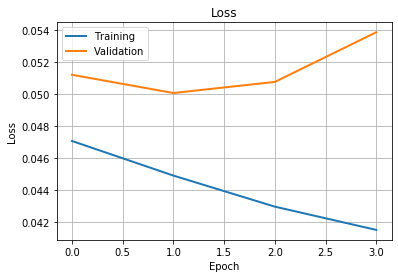

In [64]:
# Plot loss

plt.title('Loss')
plt.plot(hist.history['loss'], label='Training', linewidth=2)
plt.plot(hist.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

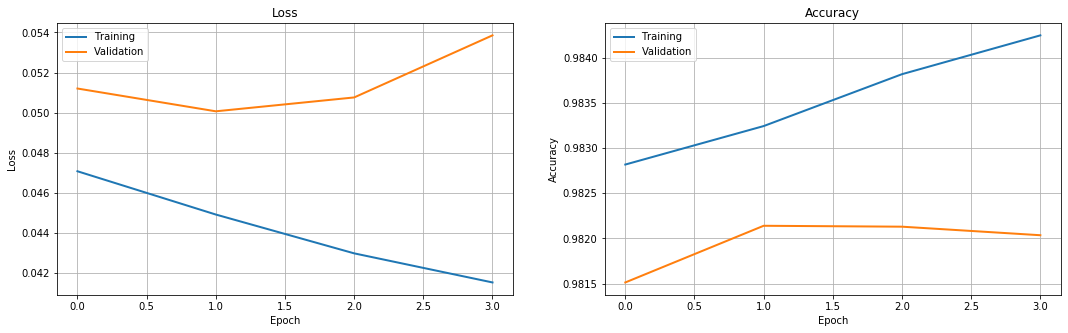

In [68]:
# Plot loss
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Training', linewidth=2)
plt.plot(hist.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Training', linewidth=2)
plt.plot(hist.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()


In [74]:
y_test_hat_ = model.predict(X_te).round()

In [92]:
toxic = pd.DataFrame(y_test_hat_,test['comment_text'])
toxic.columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [93]:
toxic

,toxic,severe_toxic,obscene,threat,insult,identity_hate
comment_text,,,,,,
"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",1.0,0.0,1.0,0.0,1.0,0.0
"== From RfC == \n\n The title is fine as it is, IMO.",0.0,0.0,0.0,0.0,0.0,0.0
""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """,0.0,0.0,0.0,0.0,0.0,0.0
":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.",0.0,0.0,0.0,0.0,0.0,0.0
I don't anonymously edit articles at all.,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
". \n i totally agree, this stuff is nothing but too-long-crap",0.0,0.0,0.0,0.0,0.0,0.0
== Throw from out field to home plate. == \n\n Does it get there faster by throwing to cut off man or direct from out fielder? \n Were the out fielders in the Mickey mantle era have better arms? \n Rich,0.0,0.0,0.0,0.0,0.0,0.0
""" \n\n == Okinotorishima categories == \n\n I see your changes and agree this is """"more correct."""" I had gotten confused, but then found this: \n :... while acknowledging Japan's territorial rights to Okinotorishima itself ... \n However, is there a category for \n :... did not acknowledge Japan's claim to an exclusive economic zone (EEZ) stemming from Okinotorishima. \n That is, is there a category for """"disputed EEZ""""s? """,0.0,0.0,0.0,0.0,0.0,0.0
